In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display as ipd
import os, glob
from librosa.feature import rms, zero_crossing_rate, mfcc
from reservoirpy.nodes import Reservoir, ESN, Ridge
from tqdm import tqdm
from numpy import hanning, convolve
from numpy.fft import fft, fftshift

#### Importing and pre-processing data

In [17]:
input_dir = './dataset/ESC-10'
subdirs = os.listdir(input_dir)
subdirs.sort()
labels = []
data = []
sample_rate = 22050
for label ,folder in tqdm(enumerate(subdirs), desc='Loading data', total=len(subdirs)):
    for file in glob.glob(input_dir + '/' + folder + '/*.ogg'):
        x = librosa.load(file, sr=sample_rate)[0]
        labels.append(label)
        data.append(x)

Loading data: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


### Sample data and Time feature visualization

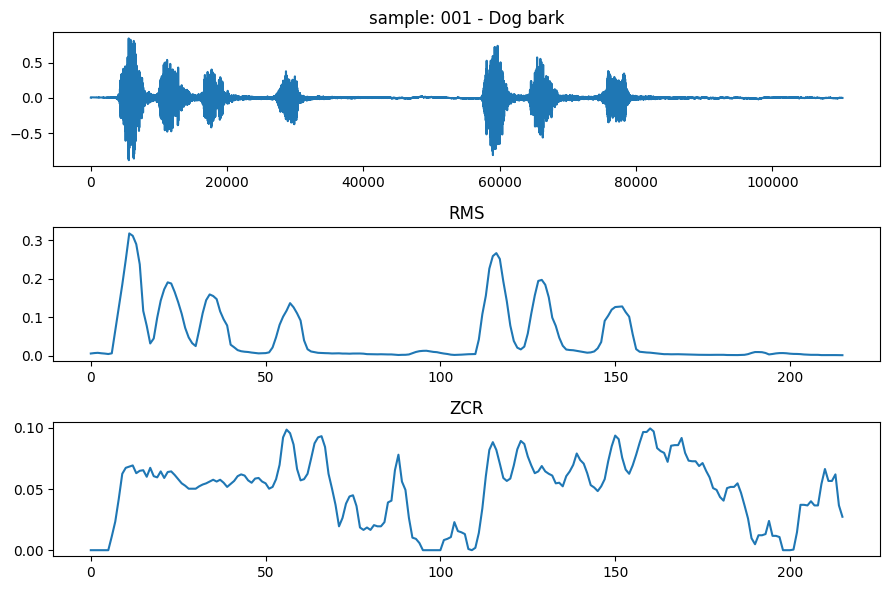

In [18]:
fig , ax = plt.subplots(nrows=3, ncols=1,figsize=(9,6))
ax[0].plot(data[10])
ax[0].set_title('sample: ' + subdirs[labels[10]])
ax[1].plot(rms(y=data[10]).reshape(-1,1))
ax[1].set_title('RMS')
ax[2].plot(zero_crossing_rate(y=data[10]).reshape(-1,1))
ax[2].set_title('ZCR')
plt.tight_layout()
plt.show()

### MFCC

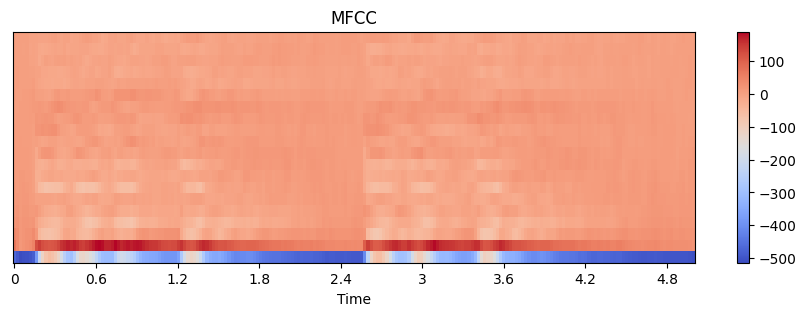

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,3))
mfccs =mfcc(y=data[10], sr=sample_rate)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.title('MFCC')
plt.show()

#### Window

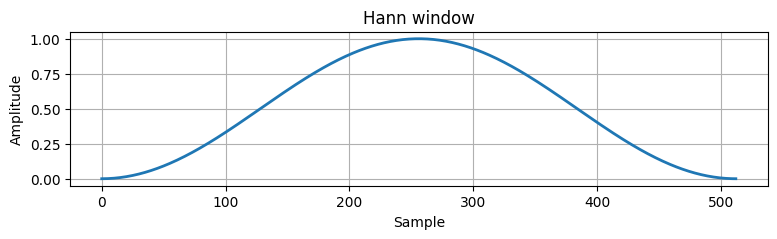

In [20]:
window = hanning(513)
plt.figure(figsize=(9,2))
plt.plot(window, label="Hann window", linewidth=2)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.grid()
plt.show()

### applying window


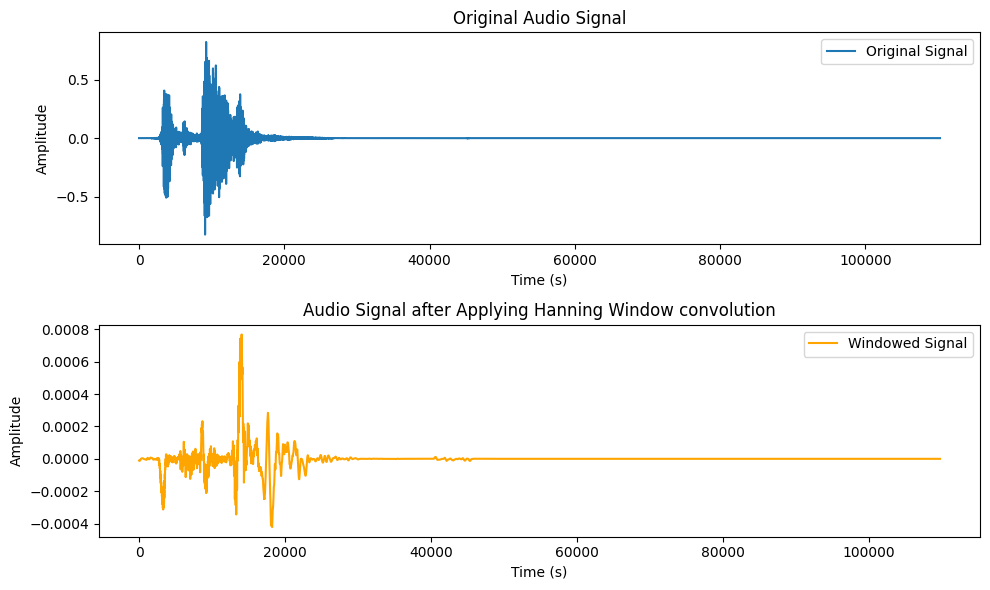

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hann, convolve


audio_signal = data[200]

# Apply Hanning window
window_size = 513
hanning_window = hanning(window_size)

# Apply the window to the audio signal
windowed_signal = convolve(audio_signal, hanning_window, mode='valid') / sum(hanning_window)
# Plot the original and windowed signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot( audio_signal, label='Original Signal')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( windowed_signal, label='Windowed Signal', color='orange')
plt.title('Audio Signal after Applying Hanning Window convolution')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


## Time Domain Windowing and Feature Extraction

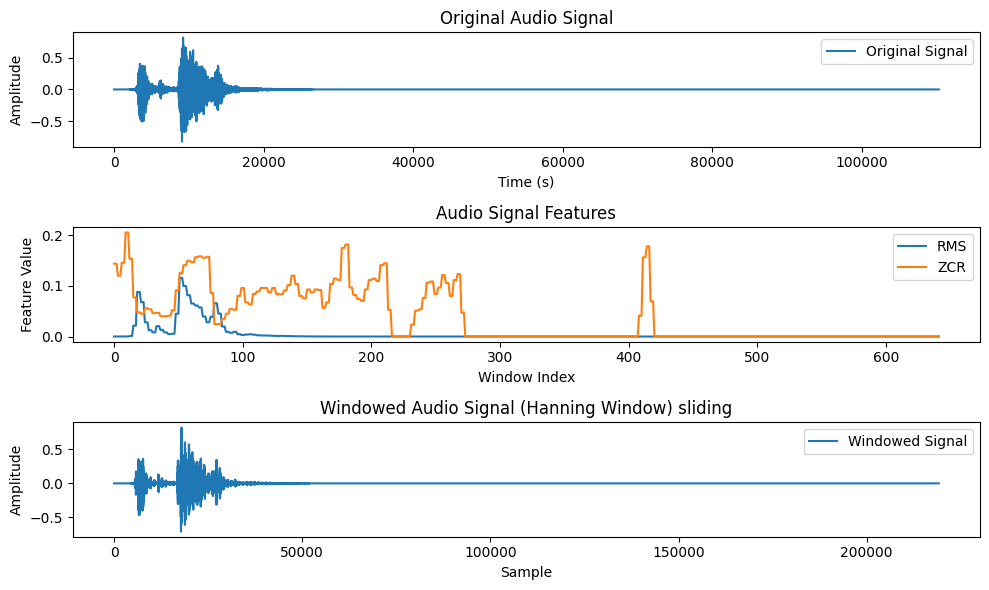

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os
import glob
from librosa.feature import rms, zero_crossing_rate
from reservoirpy.nodes import Reservoir, Ridge
from tqdm import tqdm
from numpy import hanning, convolve

def apply_sliding_window(signal, window_size, overlap):
    num_samples = len(signal)
    step_size = window_size - overlap
    num_windows = int((num_samples - window_size) / step_size) + 1
    windows = np.zeros((num_windows, window_size))

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        windows[i, :] = signal[start_idx:end_idx] * hanning(window_size)
        #windows[i, :] = convolve(signal[start_idx:end_idx], hanning(window_size), mode='valid') / sum(hanning(window_size))

    return windows

def extract_audio_features(signal,label, window_size, overlap):
    windowed_signals = apply_sliding_window(signal, window_size, overlap)
    features = []
    l = []
    for window in windowed_signals:
        rms_features = np.array([rms(y=window)]).ravel()
        zcr_features = np.array([zero_crossing_rate(y=window)]).ravel()
        features.append(np.c_[rms_features, zcr_features])
        l.append(np.zeros_like(rms_features)+label)
    return np.array(features),  np.array(l)


sample_idx = 200
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(data[sample_idx], label='Original Signal')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(extract_audio_features(data[sample_idx],labels[sample_idx] ,1024, 512)[0].reshape(-1,2), label=['RMS', 'ZCR'])
plt.title('Audio Signal Features')
plt.xlabel('Window Index')
plt.ylabel('Feature Value')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(apply_sliding_window(data[sample_idx], 1024, 512).reshape(-1), label='Windowed Signal')
plt.title('Windowed Audio Signal (Hanning Window) sliding')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
X =[]
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

(85727, 3, 2)
(85727, 3)


# RF On Time Domain

(85727, 3, 2)
(85727, 3)


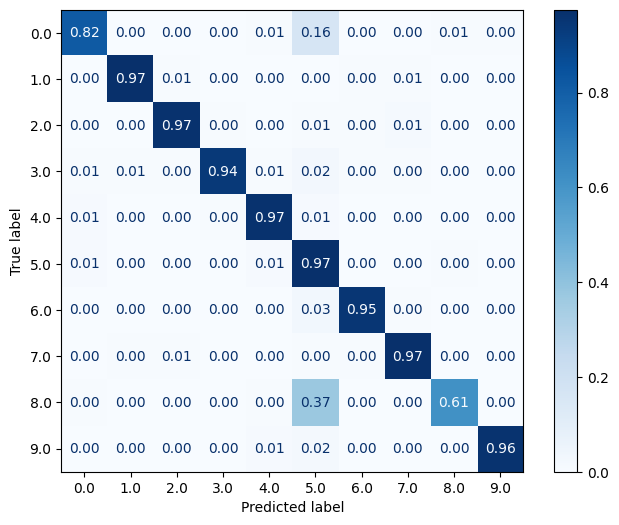

Accuracy: 91.27%
F1 Score: 91.45%


In [51]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
import seaborn as sns


X =[]
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

# Flatten the data if needed
X = X.reshape(-1, 2)  # Adjust the reshape based on your actual data structure
y = y.reshape(-1, 1).flatten()  # Adjust the reshape based on your actual data structure

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the random forest classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")


# SVM on Time Domain

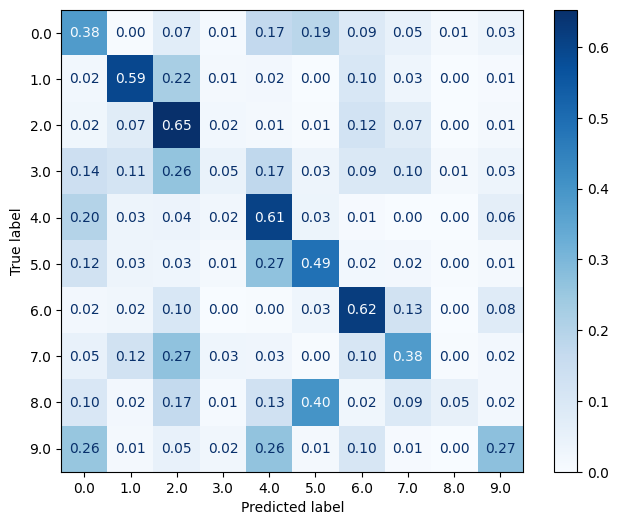

Accuracy: 40.96%
F1 Score: 37.58%


In [10]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

# Create a random SVM classifier
clf = svm.SVC(kernel='rbf', C=1.0, random_state=42)

# Train the SVM classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")

# KCCA & RF On Time Domain

 Varying std for the gaussian kernel or the window size didn't affect the performance.

(257181, 2)
(257181,)


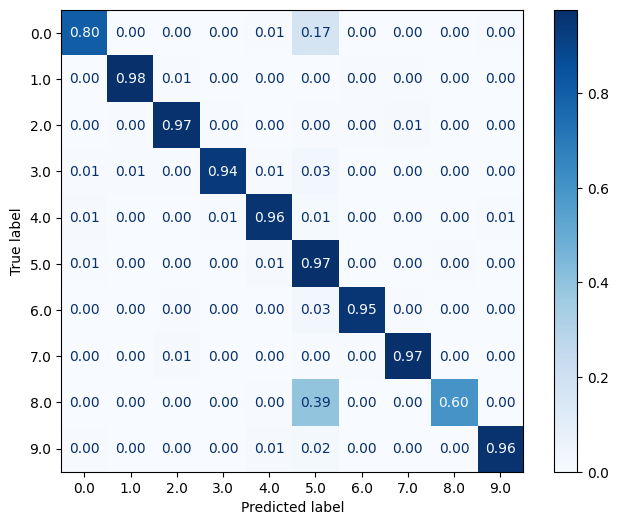

Accuracy: 91.00%
F1 Score: 91.20%


In [60]:
from sklearn.cross_decomposition import CCA
from cca_zoo.nonparametric import KMCCA

X =[]
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

# print(X.shape)
# print(y.shape)

X_kcca = []
for i in range(len(X)):
    sigma = np.std(X[i])# =1
    kernel = lambda x: np.exp(-x ** 2 / (2. * sigma ** 2))
    model = KMCCA(kernel==kernel)
    shape = X[i].shape
    model.fit(X[i].reshape(shape[0],shape[1],1))
    X_kcca.append(model.transform(X[i].reshape(shape[0],shape[1],1)))



# Split the data into training and testing sets
X = np.array(X_kcca).reshape(-1, 2)  # Adjust the reshape based on your actual data structure
print(X.shape)
y = y.reshape(-1, 1).flatten()  # Adjust the reshape based on your actual data structure
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the random forest classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")

# KCCA & SVM on Time Domain

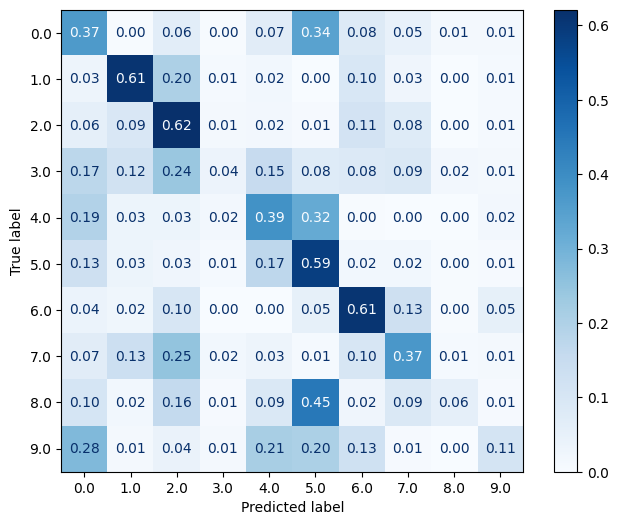

Accuracy: 37.56%
F1 Score: 33.79%


In [57]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns


# Create a random SVM classifier
clf = svm.SVC(kernel='rbf', C=1.0, random_state=42)

# Train the SVM classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")


# Reservoir on Time Domain

In [ ]:
X =[]
y = []
for i in range(len(data)):
    
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    reservoir = Reservoir(units=100, lr=0.3, sr=1.25);
    readout = Ridge(output_dim=2, ridge=1e-5);
    esn = reservoir >> readout
    features = features.reshape(-1,2)
    #print(features.shape)
    predictions = esn.fit(features[:20], features[1:21]).run(features[21:-1]);
    #print(predictions.shape)
    #print(label.shape)
    
    X.append(predictions)
    label = np.zeros_like(predictions[:,0])+labels[i]
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.flatten().shape)

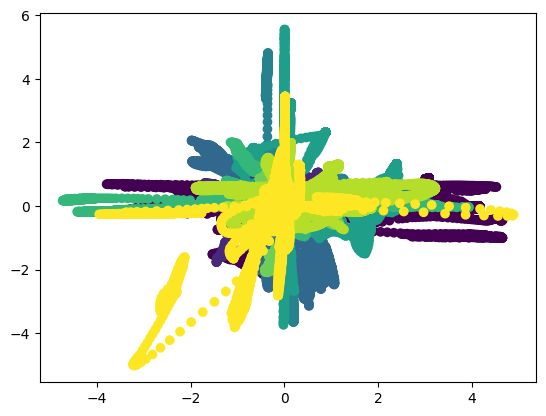

In [87]:
plt.scatter(X[:,0],X[:,1],c=y.flatten())

(248381, 2)
(248381,)


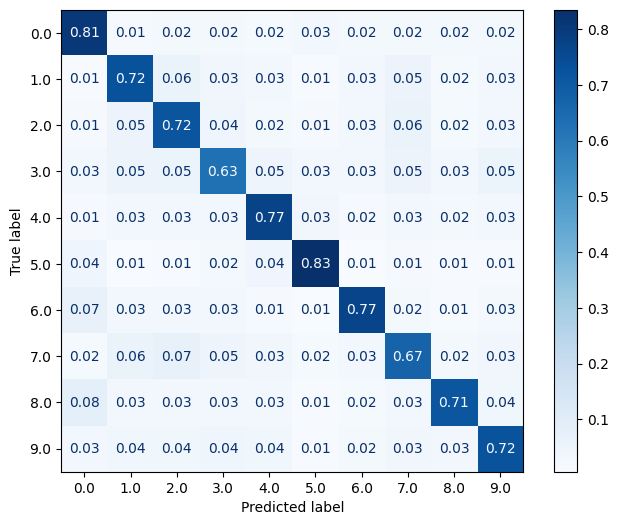

Accuracy: 73.58%
F1 Score: 73.56%


In [89]:
from sklearn.cross_decomposition import CCA
from cca_zoo.nonparametric import KMCCA

# Split the data into training and testing sets
print(X.shape)
y = y.reshape(-1, 1).flatten()  # Adjust the reshape based on your actual data structure
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the random forest classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")

In [ ]:
X = []
y = []
for i in range(len(data)):
    
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    reservoir = Reservoir(units=100, lr=0.3, sr=1.25);
    readout = Ridge(output_dim=2, ridge=1e-5);
    esn = reservoir >> readout
    features = features.reshape(-1,2)
    #print(features.shape)
    predictions = esn.fit(features[:20], features[1:21]).run(features[21:-1]);
    #print(predictions.shape)
    #print(label.shape
    sigma =1
    kernel = lambda x: np.exp(-x ** 2 / (2. * sigma ** 2))
    model = KMCCA(kernel==kernel)
    shape = predictions.shape
    model.fit(predictions.reshape(shape[0],shape[1],1))
    kcca = model.transform(predictions.reshape(shape[0],shape[1],1))
    kcca = np.array(kcca)
    X.append(kcca.reshape(-1,2))
    label = np.zeros((kcca.shape[0],1))+labels[i]
    y.append(label)
    print(kcca.shape)
    print(label.shape)

    

X = np.concatenate(X)
y = np.concatenate(y)
plt.scatter(X[:,0],X[:,1],c=y.flatten())


(248381, 2)
(248381,)


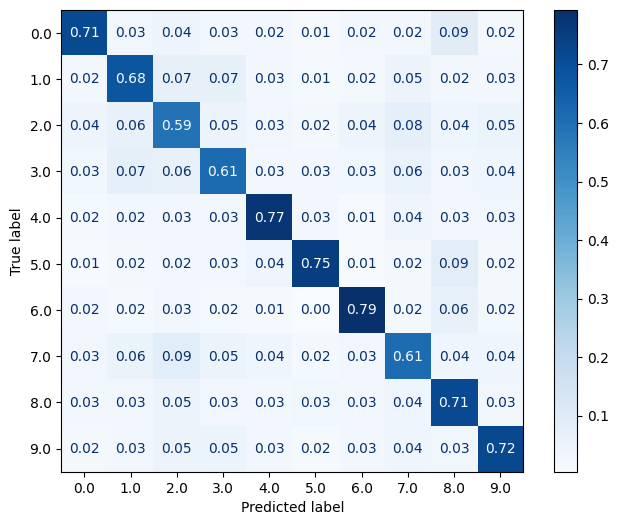

Accuracy: 69.55%
F1 Score: 69.60%


In [107]:
from sklearn.cross_decomposition import CCA
from cca_zoo.nonparametric import KMCCA

# Split the data into training and testing sets
print(X.shape)
y = y.reshape(-1, 1).flatten()  # Adjust the reshape based on your actual data structure
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the random forest classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1_score_ = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred,normalize='true')
dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
plt.figure(figsize=(8, 6))
dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
plt.show()
print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score_:.2%}")